### Inferring the spins of merging black holes in the presence of data-quality issues

Preliminary plots to visualize source properties inferred by the joint CBC and glitch model on GW200129 and GW191109

In [1]:
import bilby
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
import tqdm
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal.windows import tukey

## GW200129

In [2]:
posterior = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Moderate/FRAME_INJ/GW200129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/chains/gw_cbc_params_0.dat'

#open posteriors
with open(posterior) as f:
    first_line = f.readline().lstrip("# ").strip()
    column_names = first_line.split()
df = pd.read_csv(posterior, comment="#", sep='\s+', names=column_names)
print(df.columns)

df.head()

Index(['largeMassMsun', 'smallMassMsun', 'chirpMassMsun', 'totalMassMsun',
       'massRatio', 'largeBodyDimensionlessSpin', 'smallBodyDimensionlessSpin',
       'largeBodyCosineTilt', 'smallBodyCosineTilt',
       'largeBodyAzimuthalAngleRad', 'smallBodyAzimuthalAngleRad',
       'effectiveSpin', 'effectivePrecessingSpin',
       'firstInterferometerCoalescenceTimeSec', 'geocenterCoalescenceTimeSec',
       'H1CoalescenceTimeSec', 'L1CoalescenceTimeSec', 'geocenterPhaseRad',
       'largeBodyTidalDeformability', 'smallBodyTidalDeformability',
       'lambdaTilde', 'deltaLambdaTilde'],
      dtype='object')


,largeMassMsun,smallMassMsun,chirpMassMsun,totalMassMsun,massRatio,largeBodyDimensionlessSpin,smallBodyDimensionlessSpin,largeBodyCosineTilt,smallBodyCosineTilt,largeBodyAzimuthalAngleRad,...,effectivePrecessingSpin,firstInterferometerCoalescenceTimeSec,geocenterCoalescenceTimeSec,H1CoalescenceTimeSec,L1CoalescenceTimeSec,geocenterPhaseRad,largeBodyTidalDeformability,smallBodyTidalDeformability,lambdaTilde,deltaLambdaTilde
0,50.087618,26.464724,31.379567,76.552342,0.528369,0.065486,0.485382,1.000000,1.000000,0.000000,...,0.000000,2.021484,2.040618,2.021484,2.026367,0.000000,0,0,0,0
1,53.953995,26.725314,32.659943,80.679309,0.495335,0.323557,0.074456,0.994169,0.263326,3.320142,...,0.034890,1.940265,1.948346,1.940265,1.947305,5.945035,0,0,0,0
2,96.094454,44.024222,55.787231,140.118676,0.458135,0.676234,0.813583,0.366893,-0.671675,2.866165,...,0.629075,2.076890,2.065899,2.076890,2.079764,4.744595,0,0,0,0
3,90.999543,54.928189,61.160796,145.927732,0.603610,0.849760,0.095253,0.616721,0.620445,0.186044,...,0.668915,2.013460,2.009752,2.013460,2.022123,2.407069,0,0,0,0
4,96.070669,44.094487,55.828641,140.165156,0.458980,0.678417,0.805376,0.335090,-0.649106,3.110713,...,0.639195,2.077266,2.078961,2.077266,2.081276,4.768333,0,0,0,0


In [3]:
#open time-series
L1_data='/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Moderate/FRAME_INJ/GW200129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/data/whitened_time_domain_data_L1.dat'
L1_CBC = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Moderate/FRAME_INJ/GW200129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/post/gravitationalWave_L1_credible_interval_whitened_time.dat'
L1_glitch = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Moderate/FRAME_INJ/GW200129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/post/glitch_L1_credible_interval_whitened_time.dat'

L1_data = pd.read_csv(L1_data, skiprows=7,sep='\s+')
L1_CBC = pd.read_csv(L1_CBC, skiprows=1,sep='\s+', header=None)
L1_glitch = pd.read_csv(L1_glitch, skiprows=1,sep='\s+', header=None)

L1_glitch

,0,1,2,3,4
0,9.678079e-07,2.217848e-06,2.867583e-06,3.703183e-06,0.000005
1,-4.230167e-07,1.231235e-06,1.983828e-06,2.835755e-06,0.000004
2,-1.432373e-06,1.798696e-07,1.007239e-06,1.844742e-06,0.000003
3,-2.355258e-06,-8.430941e-07,-4.902830e-08,9.562005e-07,0.000002
4,-4.089867e-06,-1.936473e-06,-1.096191e-06,-5.764814e-08,0.000002
...,...,...,...,...,...
4091,1.461965e-06,3.303605e-06,4.212649e-06,5.021438e-06,0.000007
4092,2.089750e-06,3.638106e-06,4.469202e-06,5.348473e-06,0.000007
4093,1.723383e-06,3.672018e-06,4.465213e-06,5.181107e-06,0.000007
4094,1.495298e-06,3.410080e-06,4.218275e-06,4.871124e-06,0.000007


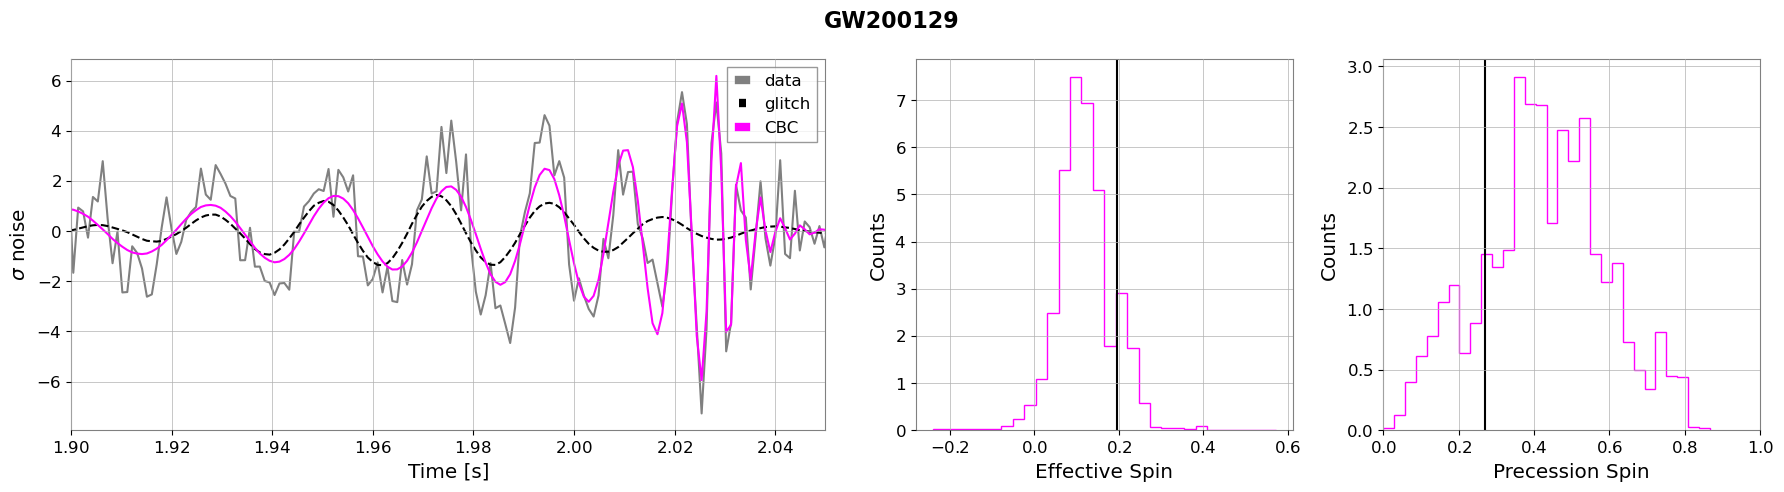

In [4]:
#visualize data, CBC and glitch model, and spins posteriors
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 1]})

# --- Plot 1: Time series with glitch and CBC ---
axs[0].plot(L1_data['domainValue'], L1_data['measuredValue'], color='grey', label='data')
axs[0].plot(L1_data['domainValue'], L1_glitch[2], color='black', linestyle='--', label='glitch')
axs[0].plot(L1_data['domainValue'], L1_CBC[2], color='magenta', label='CBC')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'$\sigma$ noise')
axs[0].legend()
axs[0].set_xlim(1.9, 2.05)

# --- Plot 2: Histogram of Effective Spin ---
axs[1].hist(df['effectiveSpin'], density=True,bins=30, histtype='step',color='magenta')
#axs[1].set_yscale('log')
axs[1].set_xlabel('Effective Spin')
axs[1].set_ylabel('Counts')
axs[1].axvline(x=0.19548317843159504,color='black')
#axs[1].set_title('Effective Spin Distribution')

# --- Plot 3: Histogram of Precession Spin ---
axs[2].hist(df['effectivePrecessingSpin'], density=True,bins=30, histtype='step', color='magenta')
#axs[2].set_yscale('log')
axs[2].set_xlabel('Precession Spin')
axs[2].set_ylabel('Counts')
axs[2].axvline(x=0.2686783330433778,color='black')
axs[2].set_xlim(0, 1)
fig.suptitle("GW200129", fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

## GW191109

In [5]:
posterior_GW191109 = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Heavy-Moderate/FRAME_INJ/GW190129_CBC_GLITCH_frame_3e6_N30_v1/bayeswave_output_0/1_main/chains/gw_cbc_params_0.dat'

with open(posterior_GW191109) as f:
    first_line = f.readline().lstrip("# ").strip()
    column_names = first_line.split()
df_GW191109 = pd.read_csv(posterior_GW191109, comment="#", sep='\s+', names=column_names)
print(df_GW191109.columns)

Index(['largeMassMsun', 'smallMassMsun', 'chirpMassMsun', 'totalMassMsun',
       'massRatio', 'largeBodyDimensionlessSpin', 'smallBodyDimensionlessSpin',
       'largeBodyCosineTilt', 'smallBodyCosineTilt',
       'largeBodyAzimuthalAngleRad', 'smallBodyAzimuthalAngleRad',
       'effectiveSpin', 'effectivePrecessingSpin',
       'firstInterferometerCoalescenceTimeSec', 'geocenterCoalescenceTimeSec',
       'H1CoalescenceTimeSec', 'L1CoalescenceTimeSec', 'geocenterPhaseRad',
       'largeBodyTidalDeformability', 'smallBodyTidalDeformability',
       'lambdaTilde', 'deltaLambdaTilde'],
      dtype='object')


In [6]:
#load time-series
L1_data_GW191109='/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Heavy-Moderate/FRAME_INJ/GW190129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/data/whitened_time_domain_data_L1.dat'
L1_CBC_GW191109 = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Heavy-Moderate/FRAME_INJ/GW190129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/post/gravitationalWave_L1_credible_interval_whitened_time.dat'
L1_glitch_GW191109 = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Heavy-Moderate/FRAME_INJ/GW190129_CBC_GLITCH_frame_1e6/bayeswave_output_0/1_main/post/glitch_L1_credible_interval_whitened_time.dat'

L1_data_GW191109 = pd.read_csv(L1_data_GW191109, skiprows=7,sep='\s+')
L1_CBC_GW191109 = pd.read_csv(L1_CBC_GW191109, skiprows=1,sep='\s+', header=None)
L1_glitch_GW191109 = pd.read_csv(L1_glitch_GW191109, skiprows=1,sep='\s+', header=None)

L1_glitch_GW191109.head()

,0,1,2,3,4
0,-0.000010,0.0,0.0,0.000022,0.000510
1,-0.000011,0.0,0.0,0.000024,0.000514
2,-0.000056,0.0,0.0,0.000017,0.000261
3,-0.000027,0.0,0.0,0.000024,0.000460
4,-0.000012,0.0,0.0,0.000026,0.000478


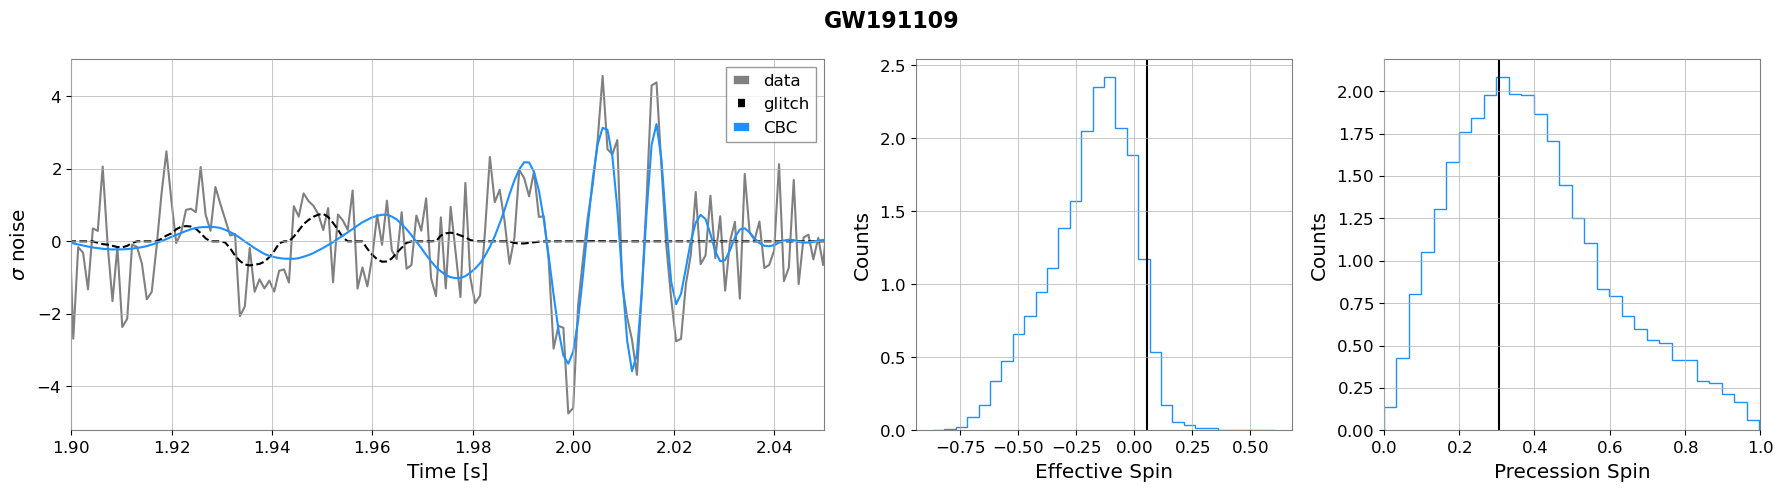

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 1]})

# --- Plot 1: Time series with glitch and CBC ---
axs[0].plot(L1_data_GW191109['domainValue'], L1_data_GW191109['measuredValue'], color='grey', label='data')
axs[0].plot(L1_data_GW191109['domainValue'], L1_glitch_GW191109[2], color='black', linestyle='--', label='glitch')
axs[0].plot(L1_data_GW191109['domainValue'], L1_CBC_GW191109[2], color='dodgerblue', label='CBC')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'$\sigma$ noise')
axs[0].legend()
axs[0].set_xlim(1.9, 2.05)

# --- Plot 2: Histogram of Effective Spin ---
axs[1].hist(df_GW191109['effectiveSpin'],bins=30,density=True, histtype='step',color='dodgerblue')
axs[1].set_xlabel('Effective Spin')
axs[1].set_ylabel('Counts')
axs[1].axvline(x=0.0532462951507371,color='black')

# --- Plot 3: Histogram of Precession Spin ---
axs[2].hist(df_GW191109['effectivePrecessingSpin'], density=True,bins=30, histtype='step', color='dodgerblue')
axs[2].set_xlabel('Precession Spin')
axs[2].set_ylabel('Counts')
axs[2].axvline(x=0.306903989704839,color='black')
axs[2].set_xlim(0, 1)
fig.suptitle("GW191109", fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
#Load results in Gaussian noise only (no glitch)
posterior_GW191109_G = '/home/sophie.bini/BW/BW_CPP/glitch_residual/Marginalization_Comparison/Heavy-Moderate/FRAME_INJ/GW190129_CBC_ONLY_frame_1e6/bayeswave_output_0/1_main/chains/gw_cbc_params_0.dat'

with open(posterior_GW191109_G) as f:
    first_line = f.readline().lstrip("# ").strip()
    column_names = first_line.split()
df_GW191109_G = pd.read_csv(posterior_GW191109_G, comment="#", sep='\s+', names=column_names)

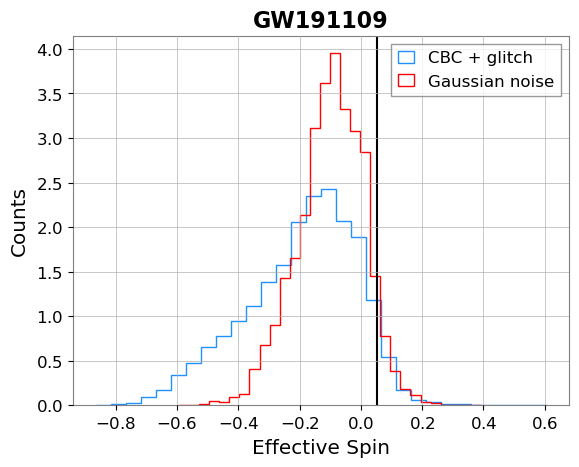

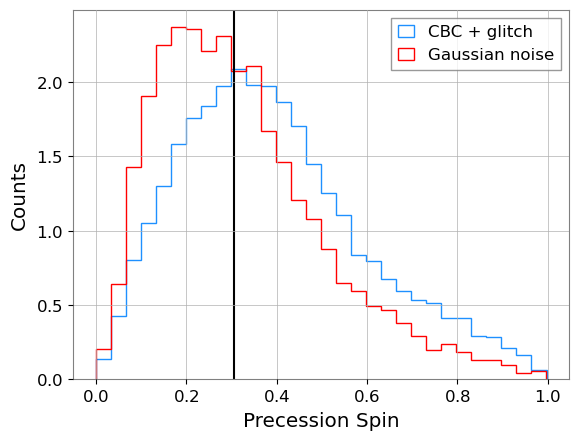

In [9]:
#Compare spin posteriors
plt.title("GW191109", fontsize=16, fontweight='bold')
plt.hist(df_GW191109['effectiveSpin'],bins=30,density=True, histtype='step',color='dodgerblue',label='CBC + glitch')
plt.hist(df_GW191109_G['effectiveSpin'],bins=30,density=True, histtype='step',color='red', label="Gaussian noise")
plt.axvline(x=0.0532462951507371,color='black')
plt.legend()
plt.xlabel('Effective Spin')
plt.ylabel('Counts')
plt.show()

plt.hist(df_GW191109['effectivePrecessingSpin'],bins=30,density=True, histtype='step',color='dodgerblue',label='CBC + glitch')
plt.hist(df_GW191109_G['effectivePrecessingSpin'],bins=30,density=True, histtype='step',color='red', label="Gaussian noise")
plt.axvline(x=0.306903989704839,color='black')
plt.xlabel('Precession Spin')
plt.ylabel('Counts')
plt.legend()
plt.show()